In [1]:
from Ranking import Ranking
import random
import numpy as np

seed = 12345
random.seed(seed)
np.random.seed(seed)

In [2]:
# Przy pierwszym czytaniu model musi z  pliku sessions.jsonl obliczyć wskaźnik populaności.
# Wtedy trzeba dać path = {path_to_jsonl_file}
#            ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓
r = Ranking(from_csv="sessions_popularity.csv", weeks=3, limit=0.25)

r.group_by_weeks()  # bierze ramke czasową o szerokości 3 tygodnie i przesuwa do przodu o tydzień. W każdej iteracji wylicza popularność
                    # dla każdego track_id jakie występuje.

100%|██████████| 51/51 [00:01<00:00, 45.14it/s]


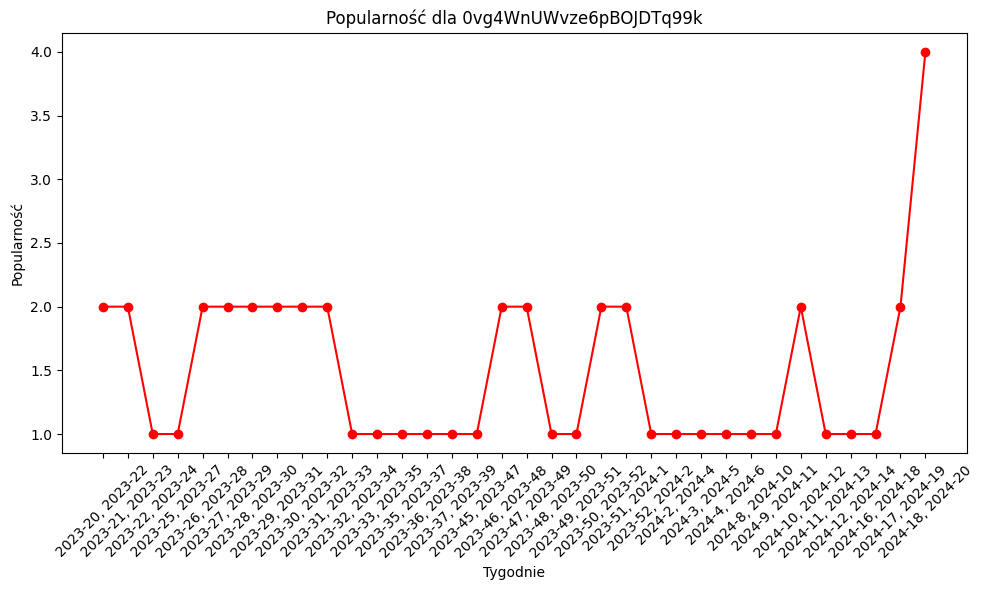

In [3]:
track = r.sessions_popularity.sample(1)
track_id = track.iloc[0]["track_id"]
r.make_plot(track_id)

Na przykładowym powyższym wykresie widać zmieniającą się popularność losowo wybranego utworu w kolejnych przedziałach czasowych. Oś x reprezentuje przedziały od rok-tydzień do rok-tydzień jako 1 argument. W modelu powyżej wzięte zostały przedziały 3-tygodniowe.


### Model bazowy

Model bazowy dla danego okresu nie wybiera utworów, które są najbardziej popularne (wedlug wyliczonego wskaźnika popularity) tylko bierze losowo zwraca id utworów z tego okresu. 


### Model docelowy

Model docelowy będzie zwracał z danego okresu czasu, część utworów o najwyższej wartości popularności.


#### Porównanie modeli

Porównanie modeli polega na sprawdzeniu ile zwróconych przez nich id_utworów faktycznie pojawi się następnym tygodniu (na podstawie sesji z przeszłości).
Założenia są takie, że oba modele zwracają taką samą ilość utworów (Jest to ograniczone przez parametr limit w modelu) oraz biorą te utwory z tych samych przedziałów czasowych o takiej samej długości.

In [4]:
r.compare_to_basic()

100%|██████████| 51/51 [00:00<00:00, 59.83it/s]

Period:    Which is better?
(2023, 20)-(2023, 22):     Basic
(2023, 21)-(2023, 23):     Extended
(2023, 22)-(2023, 24):     Extended
(2023, 23)-(2023, 25):     Extended
(2023, 24)-(2023, 26):     Extended
(2023, 25)-(2023, 27):     Extended
(2023, 26)-(2023, 28):     Extended
(2023, 27)-(2023, 29):     Extended
(2023, 28)-(2023, 30):     Extended
(2023, 29)-(2023, 31):     Extended
(2023, 30)-(2023, 32):     Extended
(2023, 31)-(2023, 33):     Extended
(2023, 32)-(2023, 34):     Extended
(2023, 33)-(2023, 35):     Extended
(2023, 34)-(2023, 36):     Extended
(2023, 35)-(2023, 37):     Extended
(2023, 36)-(2023, 38):     Extended
(2023, 37)-(2023, 39):     Extended
(2023, 38)-(2023, 40):     Extended
(2023, 39)-(2023, 41):     Extended
(2023, 40)-(2023, 42):     Extended
(2023, 41)-(2023, 43):     Extended
(2023, 42)-(2023, 44):     Extended
(2023, 43)-(2023, 45):     Extended
(2023, 44)-(2023, 46):     Extended
(2023, 45)-(2023, 47):     Extended
(2023, 46)-(2023, 48):     Extended
(20

Z powyższych wyników widać, że model docelowy wybiera trafniej utwory i działa lepiej niż losowo proponowane utwory.

In [5]:
r.make_test_for_every_frame()

100%|██████████| 51/51 [00:00<00:00, 98.73it/s] 

Ranking z tygodni: (2023, 20)-(2023, 22). Ilość trafień % w tygodniu (2023, 23): 17.165%
Ranking z tygodni: (2023, 21)-(2023, 23). Ilość trafień % w tygodniu (2023, 24): 14.733%
Ranking z tygodni: (2023, 22)-(2023, 24). Ilość trafień % w tygodniu (2023, 25): 17.004%
Ranking z tygodni: (2023, 23)-(2023, 25). Ilość trafień % w tygodniu (2023, 26): 21.19%
Ranking z tygodni: (2023, 24)-(2023, 26). Ilość trafień % w tygodniu (2023, 27): 24.09%
Ranking z tygodni: (2023, 25)-(2023, 27). Ilość trafień % w tygodniu (2023, 28): 23.45%
Ranking z tygodni: (2023, 26)-(2023, 28). Ilość trafień % w tygodniu (2023, 29): 17.89%
Ranking z tygodni: (2023, 27)-(2023, 29). Ilość trafień % w tygodniu (2023, 30): 20.56%
Ranking z tygodni: (2023, 28)-(2023, 30). Ilość trafień % w tygodniu (2023, 31): 19.037%
Ranking z tygodni: (2023, 29)-(2023, 31). Ilość trafień % w tygodniu (2023, 32): 18.194%
Ranking z tygodni: (2023, 30)-(2023, 32). Ilość trafień % w tygodniu (2023, 33): 22.321%
Ranking z tygodni: (2023, 

In [14]:
arr = []

for key, frame in r.sessions_popularity_per_weeks.items():
    arr.append(frame.shape[0])

array = np.array(arr)
print(round(array.mean(), 0))  # średnia ilość utworów

8619.0


Tak wyglądają wyniki dla modelu rozszerzonego. Co prawda nie są to duże wartości, ale z okresu 3 tygodni średnio pojawia się 8500 utworów różnych, a wzięcie 25% z nich daje ponad 2 tysiące. Więc jeśli trafność jest na poziomie 20% około to dalej 400 utworów, które zaproponowaliśmy zostało odtworzonych w następnym tygodniu. Jeśli użytkownicy faktycznie wybieraliby chętniej proponowane utwory z playlist to można założyć, że ilość trafień byłaby jeszcze większa. W tym momencie są to tylko dane z przeszłości czyli okresu kiedy użytkownicy nie mieli żadnych sugestii dotyczących utworów.